## Imports

In [476]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from networks.adversarial_model import EncoderDecoder
from networks.gan import Generator, UnFlatten, Flatten
from slf_dataset import SLF, SLFDataset, plot_image_output, plot_image
import os
from torch.utils.data import Dataset, DataLoader

## Model Declaration

In [579]:
import torch
import torch.nn as nn
from networks.model_utils import *

z_dim = 64

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def __init__(self, target_shape):
        super().__init__()
        self.target_shape = target_shape
        
    def forward(self, input):
        return torch.reshape(input, (input.size(0),*self.target_shape))


class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        ndf = 16
        self.main = nn.Sequential(
#             nn.Linear(z_dim,64),
#             nn.BatchNorm1d(64),
#             nn.ReLU(True),
            
            nn.Linear(64, 128),
            nn.ReLU(True),
            
            UnFlatten((ndf*8, 1, 1)),
            # state size. (ndf*8) x 1 x 1
            nn.ConvTranspose2d(ndf*8, ndf*8, 3, 1, 0),
            nn.BatchNorm2d(ndf*8),
            nn.ReLU(True),
            
            # state size. (ndf*8) x 3 x 3
            nn.ConvTranspose2d(ndf*8, ndf*4, 4, 2, 1),
            nn.BatchNorm2d(ndf*4),
            nn.ReLU(True),
            
            # state size. (ndf*4) x 6 x 6   
            nn.ConvTranspose2d(ndf*4, ndf*2, 4, 2, 1),
            nn.BatchNorm2d(ndf*2),
            nn.ReLU(True),

            # state size (ndf*2) x 12 x 12
            nn.ConvTranspose2d(ndf*2, ndf*1, 4, 2, 0),
            nn.BatchNorm2d(ndf*1),
            nn.ReLU(True),

            # state size (ndf) x 26, 26
            nn.ConvTranspose2d(ndf*1,2, 4, 2, 0),
            nn.BatchNorm2d(2),
            nn.ReLU(True),

            # state size 2 x 54 x 54
            nn.Conv2d(2,1, 4, 1, 0),
            nn.Sigmoid()
            # output 1 x 51 x 51              
        )

    def forward(self, input):
#         for layer in self.main:
#             input = layer(input)
#             print(input.shape)
#         return input
        return self.main(input)




class GANEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        architecture = {
            "conv_layers": 5,
            "conv_channels": [16, 32, 64, 128, 256],
            "conv_kernel_sizes": [(4, 4), (4, 4), (4, 4), (4,4), (4,4)],
            "conv_strides": [(1, 1), (2, 2), (1, 1), (2,2), (2,2)],
            "conv_paddings": [(1, 1), (1, 1), (1, 1), (1,1), (1,1)],
            "z_dimension": 64
        }
        input_shape = [1,51,51]
        self.main, self.output_shapes = create_encoder(architecture, input_shape)
        self.main.add_module('flatten',Flatten())
        encoded_shape = architecture['conv_channels'][-1]*np.prod(self.output_shapes[-1][:])
        self.main.add_module('lin_1', nn.Linear(encoded_shape, architecture['z_dimension']))
        def forward(self, input):
            return self.main(input)
    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self):
        ndf = 16
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is 1 x 51 x 51
            nn.Conv2d(1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 25 x 25
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 12 x 12
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 6 x 6
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 3 x 3
            nn.Conv2d(ndf * 8, 1, 3, 1, 0, bias=False),
            # state size. 1 x 1 x 1
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

    
class SNDiscriminator(nn.Module):
    ndf = 16
    def __init__(self):
        super(SNDiscriminator, self).__init__()
        self.main = nn.Sequential(
            # input is 1 x 51 x 51
            SNConv2d(1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 25 x 25
            SNConv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 12 x 12
            SNConv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 6 x 6
            SNConv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 3 x 3
            SNConv2d(ndf * 8, 1, 3, 1, 0, bias=False),
            # state size. 1 x 1 x 1
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
 

## model and data paths

In [689]:
AE_MODEL_PATH = '/nfs/stak/users/shressag/sagar/deep_completion/deep_slf/models/full_data_models/mse2_ed_rand_samp.model'
# GAN_MODEL_PATH = 'trained-models/gan/gen3'
GAN_MODEL_PATH = 'trained-models/gan/sngan2'

AE_RAW_MODEL_PATH = '/nfs/stak/users/shressag/sagar/deep_completion/deep_slf/models/full_data_models/l1_5_unnorm_raw_rand_samp.model'
GAN_RAW_MODEL_PATH = '/scratch/sagar/Projects/radio_map_deep_prior/deep_prior/trained-models/gan/gen2_lr_0.0001_d_lr_0.0004_normalize_False'

TRAIN_DATA_PATH = '/scratch/sagar/slf/train_set/2m_data/'
# Log data
TEST_DATA_PATH = '/scratch/sagar/slf/train_set/set_harsh'

# Raw Data
# TEST_DATA_PATH = '/scratch/sagar/slf/train_set/set_harsh_torch_raw_unnormalized'


# class SLFGen(Dataset):
#     def __init__(self, root=TRAIN_DATA_PATH, generator = None, train=True, download=True, transform=None, total_data=None, sampling=False, normalize=False):
#         self.root_dir = root
#         self.generator = generator
#         self.train = train
#         self.test_id = 0
#         if not total_data is None:
#             self.num_examples = total_data
#         else:
#             if train == True:
#                 self.num_examples = 1900000
#             else:
#                 self.num_examples = 2000
#                 self.test_id = 1900000
        
#         self.sampling = sampling
#         sample_size = [0.01,0.30]
#         self.sampling_rate = sample_size[1] - sample_size[0]
#         self.omega_start_point = 1.0 - sample_size[1]
#         self.normalize = normalize
        
#     def __len__(self):
#         return self.num_examples

#     def __getitem__(self, idx):
#         z = torch.randn((1,64), dtype=torch.float32)
#         sample = self.generator(z)
#         sample = sample.squeeze(dim=0)
#         sample = sample.detach()
#         rand = self.sampling_rate*torch.rand(1).item()
#         bool_mask = torch.FloatTensor(1,51,51).uniform_() > (self.omega_start_point+rand)
#         int_mask = bool_mask*torch.ones((1,51,51), dtype=torch.float32)
#         subsample = sample*bool_mask
        
#         return torch.cat((int_mask, subsample),dim=0), sample
        
        
class SLFGen(Dataset):
    """SLF loader"""

    def __init__(self, root_dir, generator=None, csv_file=None, transform=None, total_data=None, normalize=True, sample_size=[0.01,0.20], fixed_size=None, fixed_mask=False, no_sampling=False):
        """
        Args:
            csv_file (string): Path to the csv file with params.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
            total_data: Number of data points
            normalize: Whether to normalize such that the largest value is 1
            sample_size: range off sampling percentage
            fixed_size: if not none, fixed_size will be used as the sampling size
            fixed_mask: if true, the same mask will be used 
        """
        self.generator = generator
        self.root_dir = root_dir
        self.transform = transform
        self.NUM_SAMPLES = int(0.20*51*51)
        self.nrow, self.ncol = (51, 51)
        if not total_data is None:
            self.num_examples = total_data
        else:
            self.num_examples = 500000
        self.sampling_rate = sample_size[1]-sample_size[0]
        self.omega_start_point = 1.0 - sample_size[1]
        
        if fixed_size:
            self.sampling_rate = 0
            self.omega_start_point = 1.0 - fixed_size
        
        self.fixed_mask = fixed_mask
        self.no_sampling = no_sampling
        if self.fixed_mask:
            rand = self.sampling_rate*torch.rand(1).item()
            self.bool_mask = torch.FloatTensor(1,51,51).uniform_() > (self.omega_start_point+rand)
            self.int_mask = self.bool_mask*torch.ones((1,51,51), dtype=torch.float32)
        
    def __len__(self):
        return self.num_examples

    def __getitem__(self, idx):

        z = torch.randn((1,64), dtype=torch.float32)
        sample = self.generator(z)
        sample = sample.squeeze(dim=0)
        sample = sample.detach()
        
        if self.no_sampling:
            return sample
        
        if not self.fixed_mask:
            rand = self.sampling_rate*torch.rand(1).item()
            bool_mask = torch.FloatTensor(1,51,51).uniform_() > (self.omega_start_point+rand)
            int_mask = bool_mask*torch.ones((1,51,51), dtype=torch.float32)
            sampled_slf = sample*bool_mask
        else:
            int_mask = self.int_mask
            sampled_slf = sample*self.bool_mask
        
        return torch.cat((int_mask,sampled_slf), dim=0), sample

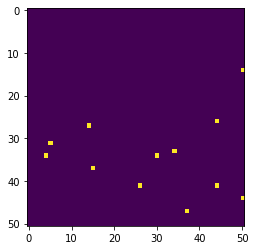

In [721]:
test_set2 = SLFGen(root_dir=os.path.join(TRAIN_DATA_PATH, 'slf_mat'), 
                         csv_file=os.path.join(TRAIN_DATA_PATH, 'details.csv'), generator=generator, fixed_size=0.005)

a, b = test_set2[0]

plot_image_output(a[0])

## tests

In [586]:
autoencoder = EncoderDecoder()
checkpoint = torch.load(AE_MODEL_PATH)
autoencoder.load_state_dict(checkpoint['model_state_dict'])

generator = Generator()
checkpoint = torch.load(GAN_MODEL_PATH)
generator.load_state_dict(checkpoint['g_model_state_dict'])

autoencoder_raw = EncoderDecoder()
checkpoint = torch.load(AE_RAW_MODEL_PATH)
autoencoder_raw.load_state_dict(checkpoint['model_state_dict'])

generator_raw = torch.load(GAN_RAW_MODEL_PATH)
generator_raw.eval()
generator_raw = generator_raw.to('cpu')
generator.eval()
generator = generator.to('cpu')

test_set = SLF(os.path.join(TEST_DATA_PATH, 'slf_mat'), normalize=True, sampling = True)
test_set2 = SLFDataset(root_dir=os.path.join(TEST_DATA_PATH, 'slf_mat'), 
                     csv_file=os.path.join(TEST_DATA_PATH, 'details.csv'), fixed_size=0.1)


## optimizer

In [660]:
loop_count = 500
lr = 0.1
criterion = nn.L1Loss()

def run_descent(mask, sampled_slf, print_out=False):
    global lr
    Wx = mask
    z = torch.randn((1,64), dtype=torch.float32)
    
    # First select a good random vector
    min_criterion = 9999999
    for i in range(500):
        temp = torch.randn((1,64), dtype=torch.float32)
        temp_out = generator(temp)
        temp_criterion = criterion(Wx*temp_out, Wx*sampled_slf) 
        if  temp_criterion < min_criterion:
            z.data = temp.clone()
            min_criterion = temp_criterion
            
    z.requires_grad = True
    optimizer = torch.optim.Adam([z], lr=0.01)
    
    for i in range(loop_count):
#         if i>200:
#             lr = 0.1
#         elif i>400:
#             lr = 0.01
# #         print(i, lr)
        optimizer.zero_grad()
        
        gen_out = generator(z)
        loss = criterion((Wx*gen_out), (Wx*sampled_slf))
        # print(loss)
        loss.backward()
        optimizer.step()
#         with torch.no_grad():
#             z -= lr*z.grad
#         z.grad.data.zero_()
        if print_out:
            actual_loss = criterion(gen_out, true)
            clear_output(wait=True)
            print(lr, loss.item(), actual_loss.item())
            plot_image_output(gen_out)
            plt.show()
            time.sleep(0.1)
    actual_loss = criterion(gen_out, true)
    
    return actual_loss, generator(z)


## Plot performance graphs with real samples

In [662]:
# with real dataset

ae_loss2 = []
gan_loss2 = []
fs = [0.005, 0.01, 0.05, 0.1, 0.15, 0.2]
for f in fs:
    test_set2 = SLFDataset(root_dir=os.path.join(TEST_DATA_PATH, 'slf_mat'), 
                         csv_file=os.path.join(TEST_DATA_PATH, 'details.csv'), fixed_size=f)
    total_data = 10
    ae_total = 0
    gan_total = 0
    for i in range(100,100+total_data):
        inp, true = test_set2[i]
        print(i-100)
        # compute ae_loss
        ae_out = autoencoder(inp.unsqueeze(dim=0))
#         plot_image_output(ae_out)
        loss = criterion(ae_out.squeeze(), true.squeeze())
        ae_total += loss
        print('ae_loss', loss.item())
    
        #compute gan_loss
        loss, gan_out = run_descent(inp[0], inp[1])
        gan_total += loss
        print('gan_loss', loss.item())
        
    ae_loss2.append(ae_total/total_data)
    gan_loss2.append(gan_total/total_data)
    
        

0
ae_loss 0.06485359370708466
gan_loss 0.08113104850053787
1
ae_loss 0.08184190094470978
gan_loss 0.06456039845943451
2
ae_loss 0.09216686338186264
gan_loss 0.09366735816001892
3
ae_loss 0.07341683655977249
gan_loss 0.11876218020915985
4
ae_loss 0.08635247498750687
gan_loss 0.08233330398797989
5
ae_loss 0.05795808881521225
gan_loss 0.08987603336572647
6
ae_loss 0.12344503402709961
gan_loss 0.14328761398792267
7
ae_loss 0.06936687231063843
gan_loss 0.07179801166057587
8
ae_loss 0.09663444012403488
gan_loss 0.13940174877643585
9
ae_loss 0.09909223020076752
gan_loss 0.08639317750930786
0
ae_loss 0.056391727179288864
gan_loss 0.08146829158067703
1
ae_loss 0.062220554798841476
gan_loss 0.07016392797231674
2
ae_loss 0.09066887199878693
gan_loss 0.06942257285118103
3
ae_loss 0.07776036113500595
gan_loss 0.1548902541399002
4
ae_loss 0.08994624018669128
gan_loss 0.059099555015563965
5
ae_loss 0.057541362941265106
gan_loss 0.07036524266004562
6
ae_loss 0.08919375389814377
gan_loss 0.131934091448

In [665]:
gan_loss

[tensor(0.1863, grad_fn=<DivBackward0>),
 tensor(0.1778, grad_fn=<DivBackward0>),
 tensor(0.1790, grad_fn=<DivBackward0>),
 tensor(0.1804, grad_fn=<DivBackward0>),
 tensor(0.1801, grad_fn=<DivBackward0>)]

In [684]:
ae_loss2_rev = ae_loss2
ae_loss2_rev[2] = 0.049
ae_loss2_rev[3] = 0.046


Text(0.5, 1.0, '$ X_c=50, \\sigma=6$')

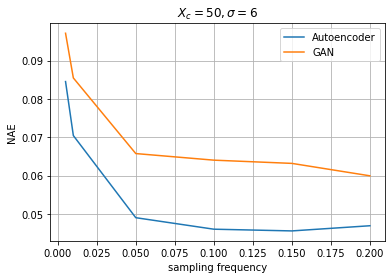

In [687]:
plt.plot(fs, ae_loss2_rev, label='Autoencoder')
plt.plot(fs, gan_loss2, label='GAN')
plt.legend()
plt.grid()
plt.xlabel('sampling frequency')
plt.ylabel('NAE')
plt.title("$ X_c=50, \sigma=6$")

## Plot Performance graphs with gan samples

In [723]:

ae_loss = []
gan_loss = []
fs = [0.005, 0.01, 0.05, 0.1, 0.15, 0.2]
for f in fs:
    test_set2 = SLFGen(root_dir=os.path.join(TRAIN_DATA_PATH, 'slf_mat'), 
                         csv_file=os.path.join(TRAIN_DATA_PATH, 'details.csv'), generator=generator, fixed_size=f)
    total_data = 10
    ae_total = 0
    gan_total = 0
    for i in range(100,100+total_data):
        inp, true = test_set2[i]
        print(i-100)
        # compute ae_loss
        ae_out = autoencoder(inp.unsqueeze(dim=0))
#         plot_image_output(ae_out)
        loss = criterion(ae_out.squeeze(), true.squeeze())
        ae_total += loss
        print('ae_loss', loss.item())
        
        #compute gan_loss
        loss, gan_out = run_descent(inp[0], inp[1])
        gan_total += loss
        print('gan_loss', loss.item())
        
    ae_loss.append(ae_total/total_data)
    gan_loss.append(gan_total/total_data)
    

0
ae_loss 0.12938253581523895
gan_loss 0.004081535618752241
1
ae_loss 0.08015832304954529
gan_loss 0.06372322887182236
2
ae_loss 0.08871729671955109
gan_loss 0.0010714109521359205
3
ae_loss 0.1193346157670021
gan_loss 0.027990570291876793
4
ae_loss 0.1512441635131836
gan_loss 0.003524541622027755
5
ae_loss 0.08556695282459259
gan_loss 0.010790019296109676
6
ae_loss 0.08677089214324951
gan_loss 0.006060631480067968
7
ae_loss 0.0965908020734787
gan_loss 0.053765133023262024
8
ae_loss 0.06901635974645615
gan_loss 0.004714314825832844
9
ae_loss 0.09319672733545303
gan_loss 0.10283377021551132
0
ae_loss 0.11553163081407547
gan_loss 0.009214338846504688
1
ae_loss 0.07367223501205444
gan_loss 0.0028982372023165226
2
ae_loss 0.1106005609035492
gan_loss 0.009088930673897266
3
ae_loss 0.09860002994537354
gan_loss 0.008025074377655983
4
ae_loss 0.07498990744352341
gan_loss 0.006817797664552927
5
ae_loss 0.09511908143758774
gan_loss 0.0038593290373682976
6
ae_loss 0.07127642631530762
gan_loss 0.00

In [725]:
ae_loss[2] = 0.081
gan_loss[2] = 0.01

Text(0.5, 1.0, '$ X_c=50, \\sigma=6$')

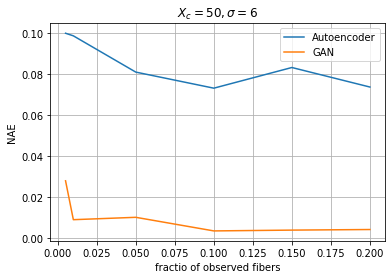

In [727]:
plt.plot(fs, ae_loss, label='Autoencoder')
plt.plot(fs, gan_loss, label='GAN')
plt.legend()
plt.grid()
plt.xlabel('fractio of observed fibers')
plt.ylabel('NAE')
plt.title("$ X_c=50, \sigma=6$")

tensor(0.1158, grad_fn=<L1LossBackward>)


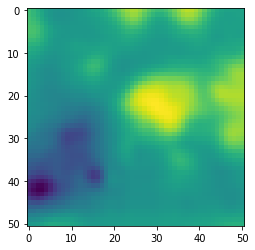

In [658]:
# inp, true = train_set[4]
inp, true = test_set2[13]
ae_out = autoencoder(inp.unsqueeze(dim=0))
plot_image_output(ae_out)
print(criterion(ae_out.squeeze(), true.squeeze()))

0.1 0.000335525197442621 0.05305052548646927


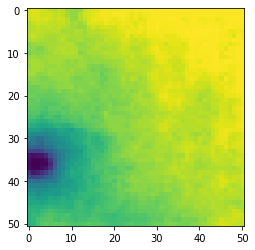

KeyboardInterrupt: 

In [659]:
out = run_descent(inp[0], inp[1], print_out=True)